# 3 - EDA

## Contents
1. [Products](#Products)
2. [Ratings](#Ratings) 
3. [Summaries](#Summaries)
4. [Reviews](#Reviews)
5. [Final DataFrame](#All-the-Pieces-Together)

Import libraries and load data

In [169]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import regex as re

In [95]:
products = pd.read_csv('/Users/myokim/Desktop/general_assembly/Projects/Capstone/datasets_clean/df_products_clean.csv')
ratings = pd.read_csv('/Users/myokim/Desktop/general_assembly/Projects/Capstone/datasets_clean/df_ratings_clean.csv')
summaries = pd.read_csv('/Users/myokim/Desktop/general_assembly/Projects/Capstone/datasets_clean/df_summaries_clean.csv')
reviews = pd.read_csv('/Users/myokim/Desktop/general_assembly/Projects/Capstone/datasets_clean/df_reviews_clean.csv')


## Products

In [4]:
# Create separate dataframes for sale and regular priced products for easier comparison
sale_prod = products[products['target'] == 1]
reg_prod = products[products['target'] == 0]

In [97]:
sale_prod.describe()

listPrice   salePrice         skuId  review_count  target    sale_pct
count  185.000000  185.000000  1.850000e+02    185.000000   185.0  185.000000
mean    30.170270   18.009730  1.935692e+06     37.318919     1.0   42.529189
std     18.926616   14.165534  1.601297e+05    118.952497     0.0   13.077130
min      6.000000    3.000000  1.359850e+06      1.000000     1.0   13.000000
25%     20.000000   10.000000  1.805563e+06      1.000000     1.0   30.400000
50%     27.000000   15.000000  1.935576e+06      5.000000     1.0   44.400000
75%     38.000000   21.750000  2.071439e+06     23.000000     1.0   50.000000
max    149.000000  105.000000  2.226785e+06    984.000000     1.0   75.000000

In [6]:
reg_prod.describe()

listPrice  salePrice         skuId  review_count  target
count  3349.000000     3349.0  3.349000e+03   3349.000000  3349.0
mean     35.671335        0.0  1.919525e+06    102.031353     0.0
std      23.486541        0.0  3.466956e+05    289.900479     0.0
min       2.000000        0.0  4.857900e+04      1.000000     0.0
25%      24.000000        0.0  1.813229e+06      1.000000     0.0
50%      30.000000        0.0  2.016699e+06      7.000000     0.0
75%      42.000000        0.0  2.166403e+06     68.000000     0.0
max     270.000000        0.0  2.282051e+06   3883.000000     0.0

From the makeup products only on Sephora, there are a total of 3,534 products. Of those 3,534 products, 185 are on sale. This makes up only 5% of the total products. The classes are very unbalanced.  
  
The average prices for sale products were less than those that were regularly priced. However, the median was more similar with median sale prices being 27 dollars and median regular sitting at 30 dollars.

In [7]:
# Save new dataframe grouped by category 
spc = pd.DataFrame(sale_prod['category'].value_counts())

In [8]:
rpc = reg_prod['category'].value_counts()

In [9]:
# Merge dataframes to have the counts of each product category
c_count = pd.merge(left = spc, right = rpc, how = 'right', left_on = spc.index, right_on = rpc.index)
c_count.fillna(0, inplace = True)

In [98]:
c_count['pct_sale'] = np.round(c_count['category_x']/(c_count['category_y']+c_count['category_x']),2)

In [99]:
c_count.sort_values(by = 'pct_sale', ascending = False).head()

key_0  category_x  category_y  pct_sale
15                     lip-plumper         4.0          25      0.14
3                  liquid-lipstick        12.0          79      0.13
7          lip-palettes-gloss-sets         8.0          52      0.13
13  fake-eyelashes-false-eyelashes         5.0          37      0.12
11           lip-liner-lip-pencils         6.0          43      0.12

In [102]:
# % of products on sale ordered in descending order 
c_count.sort_values(by = 'pct_sale', ascending = False).head()

key_0  category_x  category_y  pct_sale
15                     lip-plumper         4.0          25      0.14
3                  liquid-lipstick        12.0          79      0.13
7          lip-palettes-gloss-sets         8.0          52      0.13
13  fake-eyelashes-false-eyelashes         5.0          37      0.12
11           lip-liner-lip-pencils         6.0          43      0.12

In [103]:
# % of products on sale ordered in ascending order
c_count.sort_values(by = 'pct_sale', ascending = True).head()

key_0  category_x  category_y  pct_sale
29     bb-cc-cream-face-makeup         0.0          37      0.00
27                     mascara         0.0         202      0.00
28          tinted-moisturizer         0.0          49      0.00
26  setting-powder-face-powder         1.0         162      0.01
20           foundation-makeup         3.0         213      0.01

Unsurprisingly, the most products to go on sale are lipsticks, which also account for the most number of products. It is interesting to note that general lip products consisted of the highest percent of sale products. Products that are used very frequently like moisturizer or mascara did not go on sale at all. This may be due to the fact that these products are constantly sold.

In [14]:
sale_prod['sale_pct'] = np.round(((sale_prod['listPrice'] - sale_prod['salePrice'])/sale_prod['listPrice']),3)*100

/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
# Sort products by sale % descending order
sale_prod.groupby(by = 'category').mean().sort_values('sale_pct', ascending = False).head(5)

isLimitedEdition  isNew  isOnlineOnly  \
category                                                             
eyeshadow-primer-eye-primer          0.500000    0.0           0.0   
contour-palette-brush                0.666667    0.0           0.0   
liquid-lipstick                      0.333333    0.0           0.0   
bronzer-makeup                       0.000000    0.0           0.5   
color-correcting                     0.000000    0.0           0.0   

                             isSephoraExclusive  listPrice  salePrice  \
category                                                                
eyeshadow-primer-eye-primer                1.00  14.000000   5.000000   
contour-palette-brush                      1.00  41.333333  20.333333   
liquid-lipstick                            0.75  21.541667  10.904167   
bronzer-makeup                             0.50  37.500000  20.000000   
color-correcting                           1.00  29.750000  14.875000   

                                    skuId  review_count  target   sale_pct  
category                                                                    
eyeshadow-primer-eye-primer  1.838969e+06      8.000000     1.0  64.250000  
contour-palette-brush        1.664278e+06      3.666667     1.0  51.266667  
liquid-lipstick              1.957420e+06     85.166667     1.0  50.316667  
bronzer-makeup               1.887702e+06     10.000000     1.0  50.000000  
color-correcting             1.881976e+06      4.500000     1.0  50.000000

In [16]:
# Sort products by sale % ascending order
sale_prod.groupby(by = 'category').mean().sort_values('sale_pct', ascending = True).head(5)

isLimitedEdition  isNew  isOnlineOnly  \
category                                                                 
lip-plumper                                 0.000    0.0      0.250000   
lip-balm-treatments-lips-makeup             0.125    0.0      0.375000   
under-eye-concealer                         0.000    0.0      0.000000   
concealer                                   0.000    0.0      0.000000   
foundation-makeup                           0.000    0.0      0.333333   

                                 isSephoraExclusive  listPrice  salePrice  \
category                                                                    
lip-plumper                                0.750000  21.000000   15.25000   
lip-balm-treatments-lips-makeup            0.500000  32.000000   23.16875   
under-eye-concealer                        0.333333  30.166667   19.75000   
concealer                                  0.400000  31.700000   20.15000   
foundation-makeup                          0.666667  41.666667   25.50000   

                                        skuId  review_count  target   sale_pct  
category                                                                        
lip-plumper                      1.912338e+06      5.500000     1.0  27.100000  
lip-balm-treatments-lips-makeup  1.882576e+06      5.625000     1.0  30.350000  
under-eye-concealer              1.975177e+06    344.666667     1.0  34.466667  
concealer                        1.887799e+06    222.200000     1.0  36.840000  
foundation-makeup                1.772903e+06     15.666667     1.0  38.333333

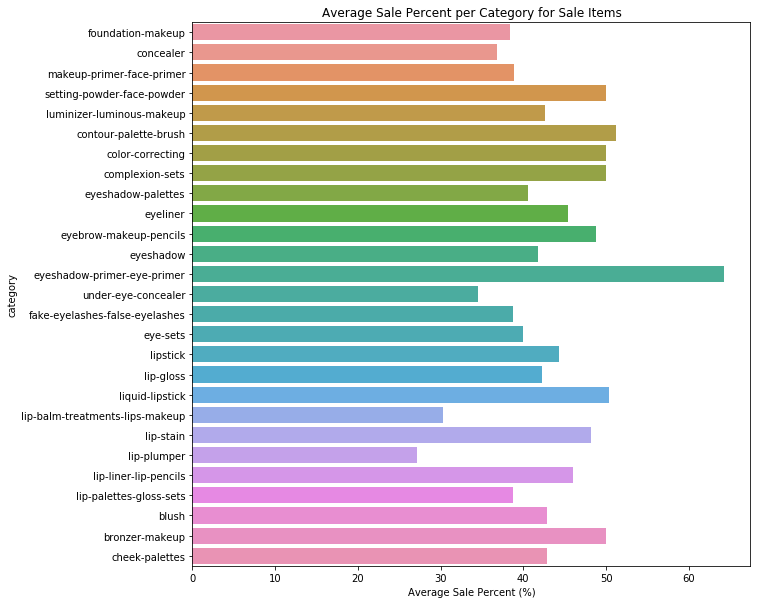

In [17]:
# Plot the average sale percent per category for sale items 
plt.figure(figsize = (10, 10))
sns.barplot(data = sale_prod, y = 'category', x = 'sale_pct', ci = None)
plt.title('Average Sale Percent per Category for Sale Items')
plt.xlabel('Average Sale Percent (%)');

Eye primers had the greatest mark down in price followed by contour palettes. It is interesting to note that more than half of these products were also limited edition. It could be that consumers did not feel the need to buy a certain product based on the fact that it was just a limited edition packaging.  

Lip products had the smallest percent of markdowns however lip products overall are not as expensive as their other makeup counterparts. Generally, lip products range from the 15-30 dollars mark while other items such a foundation or palettes will exceed 30 dollars.

Text(0.5, 1.0, 'Average Regular Price for Sale Items')

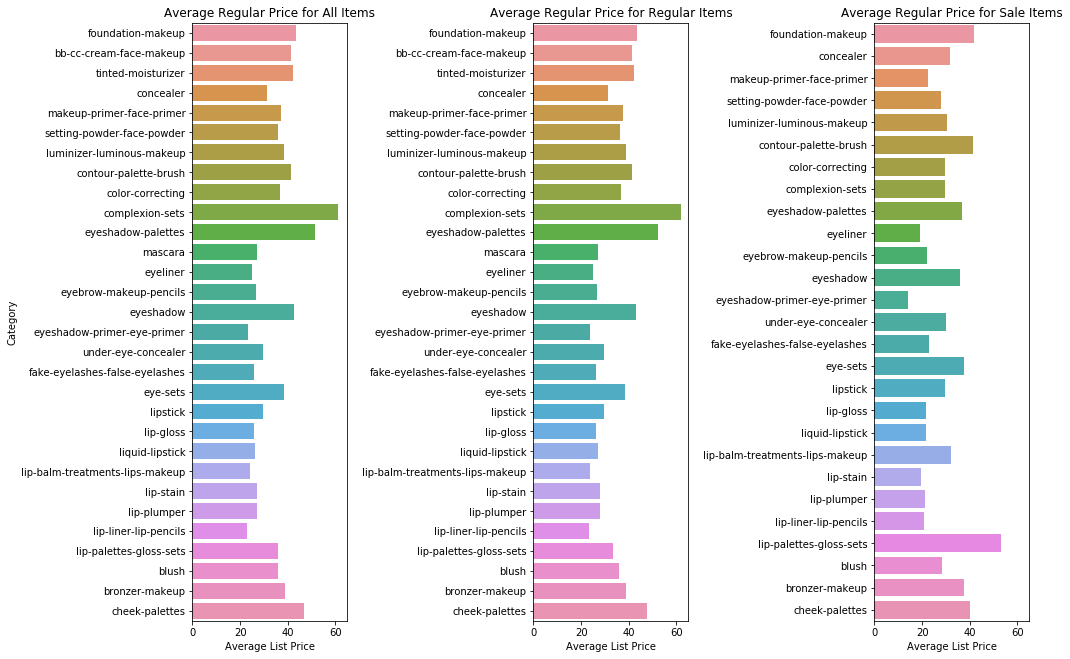

<Figure size 1080x720 with 0 Axes>

In [19]:
# Plot the average regular prices for all items, regular and sale items
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = 1.2)
plt.figure(figsize = (15, 10))
sns.barplot(data = products, x = 'listPrice', y = 'category', ci = None, ax = ax[0])

ax[0].set_ylabel('Category')
ax[0].set_xlabel('Average List Price')
ax[0].set_title('Average Regular Price for All Items')

sns.barplot(data = reg_prod, x = 'listPrice', y = 'category', ci = None, ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Average List Price')
ax[1].set_title('Average Regular Price for Regular Items')

sns.barplot(data = sale_prod, x = 'listPrice', y = 'category', ci = None, ax = ax[2])
ax[2].set_ylabel('')
ax[2].set_xlabel('Average List Price')
ax[2].set_title('Average Regular Price for Sale Items')



Comparing the average regular prices of sale and regular priced items. Sale lip palettes had higher regular prices than those not on sale. Non sale complexion and eye shadow palettes had higher regular prices than their sale counterparts. 

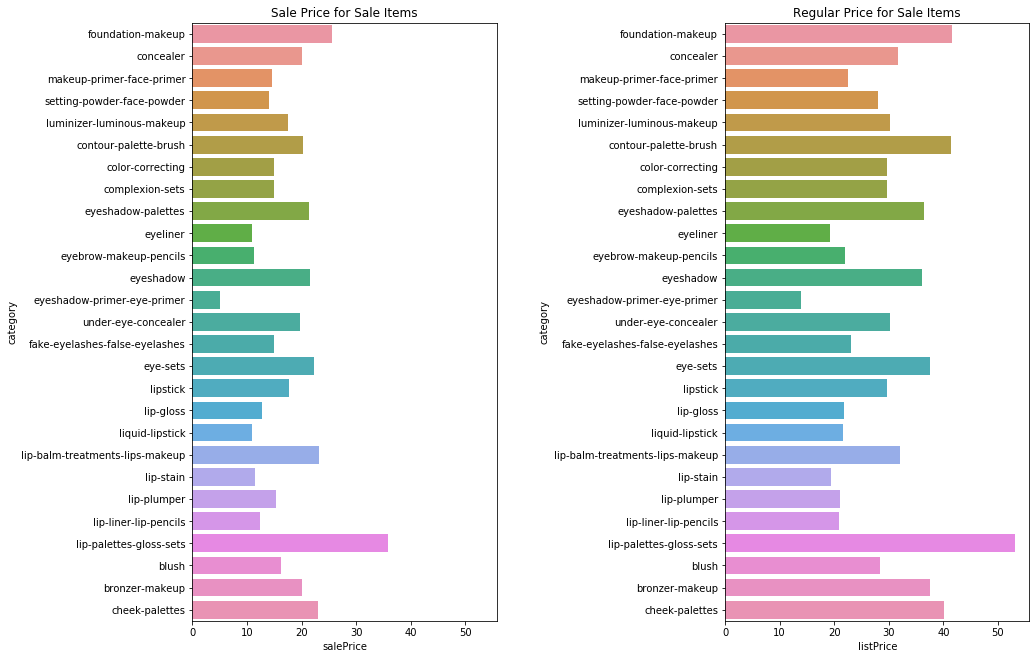

<Figure size 468x468 with 0 Axes>

In [104]:
# Comparing regular price vs sale price for sale items.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.barplot(data = sale_prod, x = 'listPrice', y = 'category', ci = None, ax = axes[1])
axes[0].set_title('Sale Price for Sale Items')
sns.barplot(data = sale_prod, x = 'salePrice', y = 'category', ci = None, ax = axes[0])
axes[1].set_title('Regular Price for Sale Items');

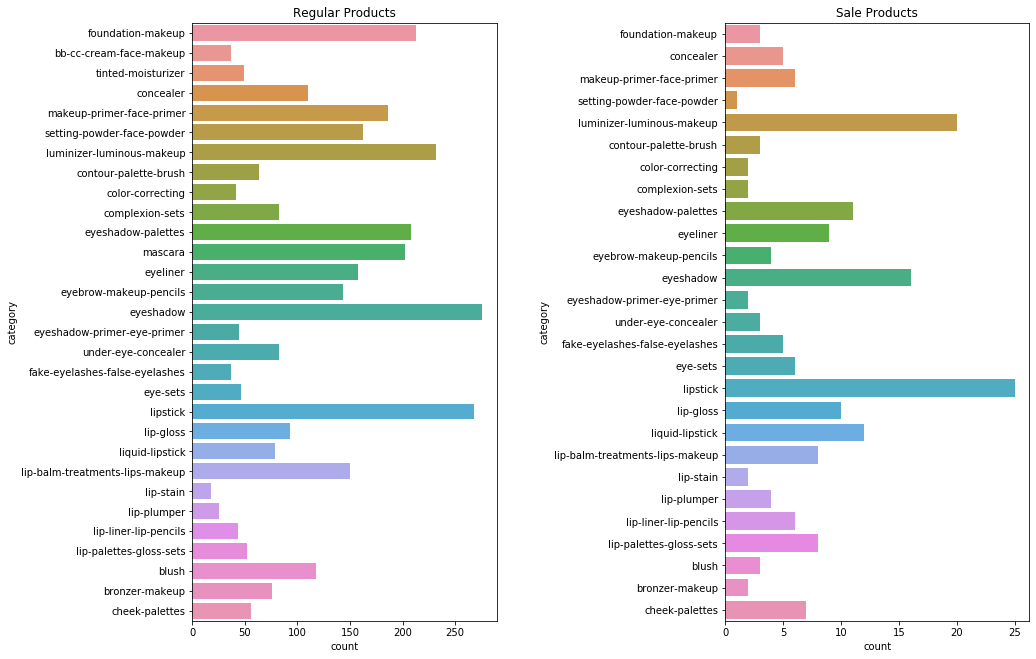

<Figure size 468x468 with 0 Axes>

In [21]:
# Value counts for each category, regular vs sale
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11))
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.countplot(data = reg_prod, y = 'category', ax = axes[0])
axes[0].set_title('Regular Products')
sns.countplot(data = sale_prod, y = 'category', ax = axes[1])
axes[1].set_title('Sale Products');

The products that went on sale the most also had the highest number of products in their categories.

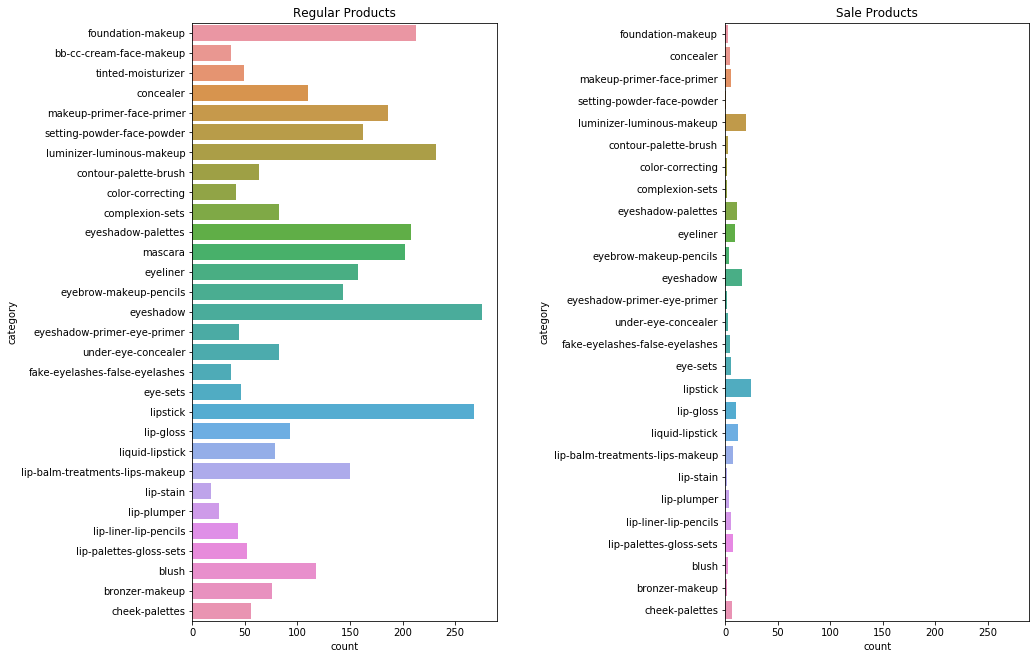

<Figure size 468x468 with 0 Axes>

In [22]:
# X-axis on the same scale
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 11), sharex = True)
plt.subplots_adjust(wspace = .75)
plt.figure(figsize = (6.5,6.5))
sns.countplot(data = reg_prod, y = 'category', ax = axes[0])
axes[0].set_title('Regular Products')
sns.countplot(data = sale_prod, y = 'category', ax = axes[1])
axes[1].set_title('Sale Products');

Using the same axis as the regular priced items gives a better sense of how often these products go on sale. Lipsticks, highlighters and eye shadows go on sale the most.

In [23]:
# New items don't go on sale
sale_prod['isNew'].value_counts()

False    185
Name: isNew, dtype: int64

In [105]:
sale_prod['brand_name'].value_counts(normalize= True)[0:5]

SEPHORA COLLECTION         0.281081
FENTY BEAUTY by Rihanna    0.081081
Black Up                   0.081081
Kat Von D                  0.075676
MAKE UP FOR EVER           0.059459
Name: brand_name, dtype: float64

In [107]:
sale_prod['listPrice'].value_counts(normalize = True,bins = 5).sort_values(ascending = False)

(5.856, 34.6]     0.708108
(34.6, 63.2]      0.264865
(91.8, 120.4]     0.016216
(120.4, 149.0]    0.010811
(63.2, 91.8]      0.000000
Name: listPrice, dtype: float64

In [26]:
reg_prod['listPrice'].value_counts(normalize = True, bins = 8).sort_values(ascending = False

(1.731, 35.5]     0.617498
(35.5, 69.0]      0.338609
(69.0, 102.5]     0.025082
(102.5, 136.0]    0.009555
(136.0, 169.5]    0.003882
(203.0, 236.5]    0.003285
(236.5, 270.0]    0.001493
(169.5, 203.0]    0.000597
Name: listPrice, dtype: float64

In [27]:
sale_prod['salePrice'].value_counts(normalize = True, bins = 5).sort_values(ascending = False)

(2.8970000000000002, 23.4]    0.794595
(23.4, 43.8]                  0.178378
(64.2, 84.6]                  0.016216
(84.6, 105.0]                 0.010811
(43.8, 64.2]                  0.000000
Name: salePrice, dtype: float64

- There were no new products that were put on sale. This makes sense.   
- The brand name that went on sale the most was Sephora's in house brand, the Sephora Collection. It would be the easiest to put their in house items on sale most frequently as they are not bound by any contracts. Also, there might be lots of inventory for their in house products.   
- Surprisingly, it looks as though price did not contribute much to whether an item goes on sale. The regular prices for sale items mostly fell under 63 dollars. Most non-sale items' regular prices also fell under 69 dollars.   
- Almost all items that went on sale had a sale price under 44 dollars.

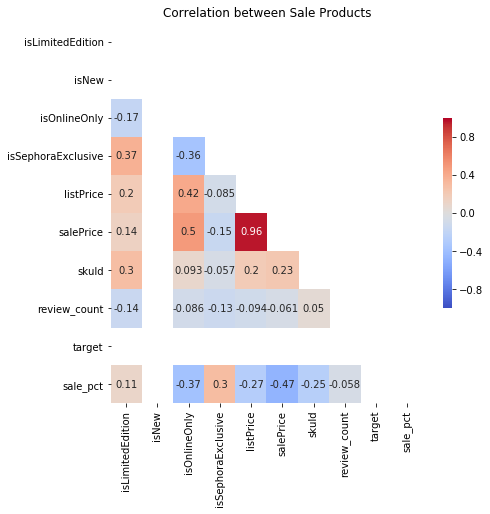

In [116]:
plt.figure(figsize = (7, 7))
plt.title('Correlation between Sale Products')

mask = np.zeros_like(sale_prod.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(sale_prod.corr(), vmin = -1, vmax= 1, cmap = 'coolwarm', annot = True, mask = mask,
            cbar_kws = {'shrink':.5})

For the sale products, the sale price is most highly correlated with list price.

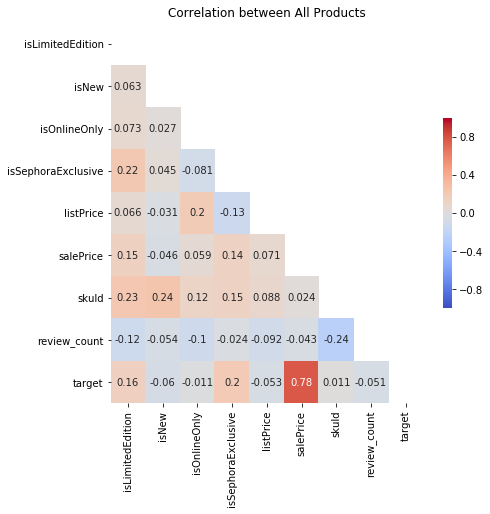

In [117]:
plt.figure(figsize = (7, 7))
plt.title('Correlation between All Products')

mask = np.zeros_like(products.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(products.corr(), vmin = -1, vmax= 1, cmap = 'coolwarm', annot = True, mask = mask,
            cbar_kws = {'shrink':.5})

For all products, the target had the highest correlation with sale price. This makes sense because the sale price will indicate whether or not a product is on sale to begi with. The variables are largely uncorrelated with one another.

The correlatio plots did not reveal anything new from the data but it is important to note that there is no multicollinearity

## Ratings

In [30]:
ratings.head()

1 star  2 stars  3 stars  4 stars  5 stars  avg_rating  product_id  \
0       0        0        0        5       11         4.7     2268274   
1      28       35       57      212      548         4.4     2257111   
2    1139     1279     1324     2149     8379         4.1     2164671   
3       1       10       23      115      214         4.5     2242105   
4     213      258      299      837     3758         4.4     2112167   

   review_count  total_ratings  target  
0            16             16       0  
1           880            880       0  
2         14270          14270       0  
3           363            363       0  
4          5365           5365       0

In [31]:
# Split the ratings by sale and regular items
sale_ratings = ratings[ratings['target'] == 1]
reg_ratings = ratings[ratings['target'] == 0]

In [32]:
sale_ratings.describe()

1 star     2 stars     3 stars      4 stars      5 stars  \
count  109.000000  109.000000  109.000000   109.000000   109.000000   
mean    23.440367   20.862385   28.889908    70.752294   167.761468   
std     48.848108   46.593289   70.305595   186.650404   414.029743   
min      0.000000    0.000000    0.000000     0.000000     1.000000   
25%      3.000000    3.000000    4.000000     6.000000    14.000000   
50%      9.000000    8.000000    8.000000    15.000000    41.000000   
75%     25.000000   16.000000   18.000000    31.000000   100.000000   
max    304.000000  313.000000  481.000000  1175.000000  2646.000000   

       avg_rating    product_id  review_count  total_ratings  target  
count  109.000000  1.090000e+02    109.000000     109.000000   109.0  
mean     3.855963  1.928570e+06    311.706422     311.706422     1.0  
std      0.534968  1.577955e+05    750.763085     750.763085     0.0  
min      1.700000  1.501428e+06      5.000000       5.000000     1.0  
25%      3.600000  1.813930e+06     33.000000      33.000000     1.0  
50%      3.900000  1.911171e+06     85.000000      85.000000     1.0  
75%      4.300000  2.060762e+06    180.000000     180.000000     1.0  
max      4.700000  2.226785e+06   4919.000000    4919.000000     1.0

In [33]:
reg_ratings.describe()

1 star      2 stars      3 stars      4 stars       5 stars  \
count  2174.000000  2174.000000  2174.000000  2174.000000   2174.000000   
mean     44.471941    45.971021    62.406164   152.092456    477.283809   
std     112.386933   106.706644   132.995034   321.259547   1141.141360   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       2.000000     3.000000     4.000000     6.000000     23.000000   
50%      10.000000    11.000000    15.000000    30.000000     98.500000   
75%      38.000000    42.750000    63.000000   149.000000    412.750000   
max    1766.000000  1742.000000  1772.000000  2989.000000  15008.000000   

        avg_rating    product_id  review_count  total_ratings  target  
count  2174.000000  2.174000e+03   2174.000000    2174.000000  2174.0  
mean      4.149770  1.875873e+06    782.225391     782.225391     0.0  
std       0.418649  3.690001e+05   1740.717521    1740.717521     0.0  
min       1.800000  5.153200e+04      1.000000       1.000000     0.0  
25%       3.900000  1.727408e+06     40.000000      40.000000     0.0  
50%       4.200000  1.968981e+06    174.500000     174.500000     0.0  
75%       4.400000  2.137183e+06    708.250000     708.250000     0.0  
max       5.000000  2.274298e+06  19413.000000   19413.000000     0.0

From a first glance, the average rating for sale products was not much lower than the average rating from regular priced items. There were much fewer ratings for sale products however. At the 75th percentile, 75% of sale items' review count fell under 180. While for regular priced products at the 50th percentile, the review count was up to 175 reviews. 

In [34]:
pd.DataFrame(sale_ratings.sum()[0:5]/sum(sale_ratings.sum()[0:5]))

0
1 star   0.075200
2 stars  0.066930
3 stars  0.092683
4 stars  0.226984
5 stars  0.538203

In [35]:
pd.DataFrame(reg_ratings.sum()[0:5]/sum(reg_ratings.sum()[0:5]))

0
1 star   0.056853
2 stars  0.058770
3 stars  0.079780
4 stars  0.194436
5 stars  0.610161

On average, sale products had more products given 1 stars or 2 stars ratings. The regular ratings also had a higher average rate of 5 star ratings

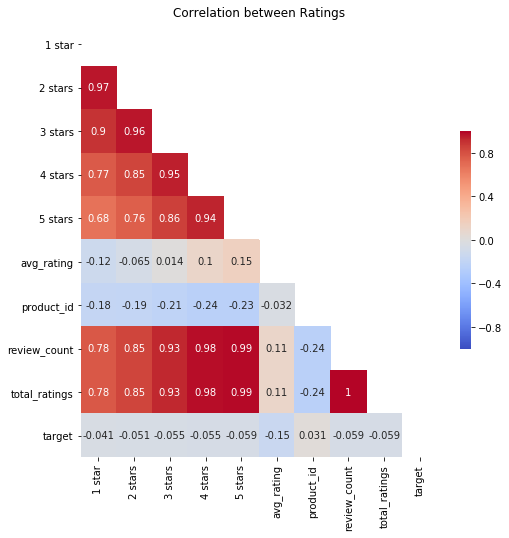

In [122]:
plt.figure(figsize = (8, 8))
plt.title('Correlation between Ratings')

mask = np.zeros_like(ratings.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(ratings.corr(), vmin = -1, vmax= 1, cmap = 'coolwarm', annot = True, mask = mask,
            cbar_kws = {'shrink':.5})



The ratings were highly correlated with one another. The total average rating had the highest correlation between the target.

## Summaries

In [37]:
summaries.head()

product_id  a little go a long way  absorbs quickly  affordable  amazing  \
0       51532                     0.0              0.0         0.0      2.0   
1       51573                     0.0              0.0         2.0      0.0   
2       51904                     0.0              0.0         0.0      3.0   
3       52852                     0.0              0.0         0.0      3.0   
4       54312                     0.0              0.0         0.0      1.0   

   awesome  awful  beautiful  beautiful color  blend easily  ...  very black  \
0      1.0    0.0        1.0              0.0           1.0  ...         0.0   
1      0.0    0.0        0.0              0.0           0.0  ...         0.0   
2      0.0    0.0        0.0              0.0           0.0  ...         0.0   
3      0.0    0.0        0.0              0.0           0.0  ...         0.0   
4      0.0    0.0        1.0              0.0           0.0  ...         0.0   

   very pigmented  vibrant  volumizing  water resistant  waterproof  watery  \
0             0.0      0.0         0.0              0.0         0.0     0.0   
1             0.0      0.0         0.0              0.0         0.0     0.0   
2             0.0      0.0         0.0              0.0         0.0     0.0   
3             0.0      0.0         0.0              0.0         0.0     0.0   
4             0.0      0.0         0.0              0.0         0.0     0.0   

   weightless  wonderful  target  
0         0.0        0.0       0  
1         0.0        0.0       0  
2         0.0        0.0       0  
3         0.0        0.0       0  
4         0.0        0.0       0  

[5 rows x 203 columns]

In [39]:
# Instantiate sentiment analyzer from NLTK library
sid = SentimentIntensityAnalyzer()

In [40]:
# Get the sentiment of the key word/statements using Sentiment Analyzer
key_word_weights = {}
for words in summaries.columns:
    key_word_weights[words] = {}
    ss = sid.polarity_scores(words)
    for k in sorted(ss):
        key_word_weights[words][k] = ss[k]

In [41]:
key_word_sentiment = pd.DataFrame.from_dict(key_word_weights, orient = 'index')

In [42]:
key_word_sentiment.head()

compound  neg  neu  pos
a little go a long way    0.0000  0.0  1.0  0.0
absorbs quickly           0.0000  0.0  1.0  0.0
affordable                0.0000  0.0  1.0  0.0
amazing                   0.5859  0.0  0.0  1.0
awesome                   0.6249  0.0  0.0  1.0

In [128]:
# Get the total keyword frequency to create column weights
summaries['total'] = summaries.drop(columns = ['target', 'product_id']).sum(axis = 1)

In [129]:
summaries.shape

(904, 204)

In [130]:
summaries.head()

product_id  a little go a long way  absorbs quickly  affordable  amazing  \
0       51532                     0.0              0.0         0.0      2.0   
1       51573                     0.0              0.0         2.0      0.0   
2       51904                     0.0              0.0         0.0      3.0   
3       52852                     0.0              0.0         0.0      3.0   
4       54312                     0.0              0.0         0.0      1.0   

   awesome  awful  beautiful  beautiful color  blend easily  ...  \
0      1.0    0.0        1.0              0.0           1.0  ...   
1      0.0    0.0        0.0              0.0           0.0  ...   
2      0.0    0.0        0.0              0.0           0.0  ...   
3      0.0    0.0        0.0              0.0           0.0  ...   
4      0.0    0.0        1.0              0.0           0.0  ...   

   very pigmented  vibrant  volumizing  water resistant  waterproof  watery  \
0             0.0      0.0         0.0              0.0         0.0     0.0   
1             0.0      0.0         0.0              0.0         0.0     0.0   
2             0.0      0.0         0.0              0.0         0.0     0.0   
3             0.0      0.0         0.0              0.0         0.0     0.0   
4             0.0      0.0         0.0              0.0         0.0     0.0   

   weightless  wonderful  target   total  
0         0.0        0.0       0   723.0  
1         0.0        0.0       0  2291.5  
2         0.0        0.0       0   857.0  
3         0.0        0.0       0   712.0  
4         0.0        0.0       0   100.0  

[5 rows x 204 columns]

In [131]:
# Get the weighted value for each key word 
summaries_weights = summaries.drop(columns = ['target', 'product_id']).div(summaries['total'], axis = 0)

In [47]:
# Add back in the product_id 
summaries_weights = pd.concat([summaries[['product_id']], summaries_weights], axis = 1)

In [48]:
# Get the weighted compound score for the key words
summaries_weights['compound_score'] = None
for i_1 in range(len(summaries_weights)):
    compound = 0
    for i_2 in range(len(key_word_sentiment)):
        if key_word_sentiment.index[i_2] in summaries_weights.iloc[i_1][1:]:
            
            # Compound score of word multiplied by each word weight to get total compound score for the product
            compound += key_word_sentiment.iloc[i_2]['compound'] * summaries_weights.iloc[i_1][key_word_sentiment.index[i_2]]
    summaries_weights.at[i_1, 'compound_score'] = compound

In [49]:
# Add back in target after as target might be a key word
summaries_weights = pd.concat([summaries[['target']], summaries_weights], axis = 1)

In [50]:
# Split the summaries into sale vs regular
sale_summaries = summaries_weights[summaries_weights['target'] == 1]
reg_summaries = summaries_weights[summaries_weights['target'] == 0]

In [51]:
sale_summaries.head()

target  product_id  a little go a long way  absorbs quickly  affordable  \
215       1     1501428                     0.0              0.0    0.000000   
264       1     1582741                     0.0              0.0    0.000000   
297       1     1636737                     0.0              0.0    0.003543   
324       1     1662303                     0.0              0.0    0.000000   
335       1     1670892                     0.0              0.0    0.000000   

     amazing  awesome  awful  beautiful  beautiful color  ...  very pigmented  \
215      0.0      0.0    0.0   0.000000          0.00232  ...             0.0   
264      0.0      0.0    0.0   0.000000          0.00000  ...             0.0   
297      0.0      0.0    0.0   0.001771          0.00000  ...             0.0   
324      0.0      0.0    0.0   0.000000          0.00000  ...             0.0   
335      0.0      0.0    0.0   0.000000          0.00000  ...             0.0   

     vibrant  volumizing  water resistant  waterproof   watery  weightless  \
215      0.0         0.0              0.0    0.000000  0.00464         0.0   
264      0.0         0.0              0.0    0.000000  0.00000         0.0   
297      0.0         0.0              0.0    0.000000  0.00000         0.0   
324      0.0         0.0              0.0    0.000000  0.00000         0.0   
335      0.0         0.0              0.0    0.098039  0.00000         0.0   

     wonderful  total  compound_score  
215        0.0    1.0       0.0148494  
264        0.0    1.0        0.159426  
297        0.0    1.0         0.22675  
324        0.0    1.0               0  
335        0.0    1.0      0.00863529  

[5 rows x 205 columns]

In [147]:
# Sum of total key word count
sum(summaries[summaries['target'] == 1].drop(columns = ['product_id', 'total']).sum().sort_values(ascending = False))

14261.0

In [148]:
# % of key words for sale products
summaries[summaries['target'] == 1].drop(columns = ['product_id', 'total']).sum().sort_values(ascending = False)[:5]/14261

full coverage    0.165767
lightweight      0.118225
nondrying        0.103990
creamy           0.088844
long wearing     0.082463
dtype: float64

In [149]:
# Sum of total key word count
sum(summaries[summaries['target'] == 0].drop(columns = ['product_id', 'total']).sum().sort_values(ascending = False))

880003.0

In [150]:
# % of key words for sale products
summaries[summaries['target'] == 0].drop(columns = ['product_id', 'total']).sum().sort_values(ascending = False)[:5]/880003

long wearing          0.115468
lengthening           0.065950
volumizing            0.057891
defining              0.055737
buildable coverage    0.050088
dtype: float64

Interestingly, for the keywords seen in sale item reviews, the key words were mostly positive words. There were also many similarities in the top key words for the regular and sale priced items.

Looking at sentiment..

In [54]:
sale_summaries['compound_score'].mean()

0.062303584137837695

In [55]:
reg_summaries['compound_score'].mean()

0.06157498137865135

Interestingly, the sentiment compound scores for sale and reg summaries was nearly the same with sale summaries actually being higher by .001

In [159]:
sale_summaries['compound_score'].value_counts(normalize = True, bins = 5).sort_values(ascending = True)

(0.24, 0.328]                      0.000000
(0.328, 0.417]                     0.022727
(0.0628, 0.151]                    0.113636
(0.151, 0.24]                      0.181818
(-0.027200000000000002, 0.0628]    0.681818
Name: compound_score, dtype: float64

In [160]:
reg_summaries['compound_score'].value_counts(normalize = True, bins = 5).sort_values(ascending = True)

(0.373, 0.471]       0.006977
(0.274, 0.373]       0.016279
(0.176, 0.274]       0.076744
(0.0778, 0.176]      0.203488
(-0.0221, 0.0778]    0.695349
Name: compound_score, dtype: float64

The range for compound scores was nearly identical for sale and regular products. Regular products saw a greater percentage of products with less favorable compound scores

In [492]:
compound_summaries = summaries_weights[['compound_score', 'product_id']]

## Reviews

In [163]:
reviews.drop_duplicates(subset = 'review', inplace = True)

In [164]:
reviews.reset_index(drop = True, inplace = True)

In [165]:
# Stem reviews 
p_stem = PorterStemmer()
reviews['stem'] = reviews['review'].apply(lambda x: 
                               re.sub('[^a-zA-Z\s]', "", 
                                      " ".join([p_stem.stem(word) for word in str(x).split()])).strip())

In [171]:
stopwords = stopwords.words('english')

In [172]:
# Remove stop words 
reviews['review_nsw'] = reviews['review'].apply(lambda x: 
                                                " ".join([word for word in str(x).split() if word not in stopwords]))

In [173]:
# Stem and remove stop words 
reviews['stem_nsw'] = reviews['review_nsw'].apply(lambda x: 
                               re.sub('[^a-zA-Z\s]', "", 
                                      " ".join([p_stem.stem(word) for word in str(x).split()])).strip())

In [174]:
# Get the compound scores for the review
reviews['compound'] = None
reviews['pos'] = None
reviews['neg'] = None
reviews['neu'] = None
for i in range(len(reviews['review'])):
    ss = sid.polarity_scores(reviews['review'][i])
    for k in sorted(ss):
        reviews.at[i, k] = float(ss[k])

When testing the reviews and compound scores on different variations of the review (stemmed, removed stop words), using the entire review itself gave the most accurate compound score. Because VADER (NLTK's sentiment analysis tool) is able to understand things like caps lock and punctuation and incorporate it into the score, using the entire review gave the most accurate score.

In [175]:
reviews.head()

age_range eye_color  product_id  rating  \
0       NaN     Brown     2268274       5   
1       NaN     Brown     2268274       5   
2       NaN     Brown     2268274       5   
3       NaN     Brown     2268274       5   
4     18-24     Brown     2268274       4   

                                              review skin_tone    skin_type  \
0  WOW! I love this foundation, and the packaging...     Olive  Combination   
1  I mean do you really have to know that she did...      Deep       Normal   
2  So i normally use the matte Fenty Matte Founda...      Deep  Combination   
3  A natural finish and at the same time gives co...       NaN         Oily   
4  Uh, at first I wanted to rate this a tad bit l...      Dark  Combination   

                                               title          user  target  \
0  Love this foundation in addition to the soft m...      TyraFox        0   
1                                       And ANOTHER!     KendraAb        0   
2                                 Food For Your Skin  UGBASTIAN89        0   
3         Feels airy and fresh with natural coverage        veens        0   
4                                          Oh man...     KhrisGal        0   

                                                stem  \
0  wow I love thi foundation and the packag is ev...   
1  I mean do you realli have to know that she did...   
2  So i normal use the matt fenti matt foundat wh...   
3  A natur finish and at the same time give cover...   
4  uh at first I want to rate thi a tad bit lower...   

                                          review_nsw  \
0  WOW! I love foundation, packaging even better!...   
1  I mean really know again. I actually combinati...   
2  So normally use matte Fenty Matte Foundation I...   
3  A natural finish time gives coverage. It didnt...   
4  Uh, first I wanted rate tad bit lower due comb...   

                                            stem_nsw compound    pos    neg  \
0  wow I love foundation packag even better iv us...   0.9566  0.295      0   
1  I mean realli know again I actual combin skin ...   0.9734  0.227      0   
2  So normal use matt fenti matt foundat I absolu...   0.9611  0.182  0.029   
3  A natur finish time give coverage It didnt fee...   0.8111  0.195  0.082   
4  uh first I want rate tad bit lower due combo l...    0.906  0.213   0.06   

     neu  
0  0.705  
1  0.773  
2  0.789  
3  0.723  
4  0.727

The positive, negative and neutral scores indicate the percent of each that the sentence encompasses. So for the first review, it is 70% positive and 30% negative. Overall, it is mostly positive with a compound score of 96%. The compound score is calculated by taking the rating from VADER's lexicon ratings. It then scales to score to be from -1 to 1 and sums to get the final compound score. For example, good has a rating of 1.9 in VADER's dictionary.

In [176]:
reviews['length'] = reviews['review'].map(lambda x: len(x))

In [177]:
# Check the data type 
reviews.dtypes

age_range     object
eye_color     object
product_id     int64
rating         int64
review        object
skin_tone     object
skin_type     object
title         object
user          object
target         int64
stem          object
review_nsw    object
stem_nsw      object
compound      object
pos           object
neg           object
neu           object
length         int64
dtype: object

In [178]:
# Change the sentiment scores to floats
for col in ['compound', 'pos', 'neg', 'neu']:
    reviews[col] = reviews[col].map(lambda x: float(x))

In [180]:
reviews.groupby(by = 'product_id').mean()['compound'].value_counts(normalize = True, bins = 5)

(0.383, 0.682]      0.538739
(0.682, 0.982]      0.391592
(0.0832, 0.383]     0.064865
(-0.216, 0.0832]    0.003604
(-0.518, -0.216]    0.001201
Name: compound, dtype: float64

Most product reviews were much more positive than they were negative

In [181]:
reviews['compound'].value_counts(normalize = True, bins = 5)

(0.602, 0.999]      0.712829
(0.206, 0.602]      0.127779
(-0.191, 0.206]     0.070691
(-0.587, -0.191]    0.052382
(-0.987, -0.587]    0.036319
Name: compound, dtype: float64

Overall, there were much more positive reviews than negative

In [184]:
reviews[reviews['target'] == 1]['compound'].value_counts(normalize = True, bins = 5)

(0.607, 0.997]      0.646801
(0.217, 0.607]      0.136763
(-0.173, 0.217]     0.083438
(-0.563, -0.173]    0.069636
(-0.955, -0.563]    0.063363
Name: compound, dtype: float64

In [185]:
reviews[reviews['target'] == 0]['compound'].value_counts(normalize = True, bins = 5)

(0.602, 0.999]      0.715662
(0.206, 0.602]      0.127402
(-0.191, 0.206]     0.070145
(-0.587, -0.191]    0.051549
(-0.987, -0.587]    0.035242
Name: compound, dtype: float64

Sale products had greater percentage of negative compound scores than regular priced products.

In [73]:
compound_ratings = pd.DataFrame(reviews.groupby(by = 'product_id').mean()['compound'])

In [88]:
top_10_users = reviews['user'].value_counts()[1:11].index

In [89]:
top_10_users

Index(['mistyrayne ', 'Mochapj ', 'glowholic ', 'makeupfreak12 ',
       'TheMACIsBack ', 'Ellen5 ', 'jonieku ', 'crisymei ', 'Mallerlyn ',
       'NOneRouge '],
      dtype='object')

Check to see the demographics of the most review writing users

In [94]:
reviews[reviews['user'].isin(top_10_users)].groupby(by = 'user').mean()

product_id    rating    target  compound       pos  \
user                                                                   
Ellen5          2.066659e+06  4.619048  0.000000  0.896986  0.207286   
Mallerlyn       1.792742e+06  4.700000  0.050000  0.861175  0.340400   
Mochapj         2.102204e+06  4.333333  0.000000  0.757022  0.180528   
NOneRouge       1.612719e+06  2.210526  0.000000  0.276605  0.179368   
TheMACIsBack    1.907231e+06  4.791667  0.041667  0.902738  0.242583   
crisymei        1.697232e+06  3.400000  0.000000  0.687500  0.178900   
glowholic       1.936471e+06  4.218750  0.000000  0.736937  0.186969   
jonieku         1.994725e+06  4.333333  0.190476  0.688214  0.210857   
makeupfreak12   2.033092e+06  3.312500  0.000000  0.655100  0.171375   
mistyrayne      1.865321e+06  3.711538  0.019231  0.693812  0.222019   

                     neg       neu      length  
user                                            
Ellen5          0.024619  0.768048  491.714286  
Mallerlyn       0.010200  0.649450  150.750000  
Mochapj         0.023000  0.796389  454.027778  
NOneRouge       0.060684  0.760000   99.052632  
TheMACIsBack    0.032417  0.724875  589.875000  
crisymei        0.047300  0.773750  600.600000  
glowholic       0.037000  0.775969  489.187500  
jonieku         0.049857  0.739238  508.523810  
makeupfreak12   0.023438  0.805219  308.625000  
mistyrayne      0.037308  0.740731  261.038462

In [203]:
reviews.head(0)

Empty DataFrame
Columns: [age_range, eye_color, product_id, rating, review, skin_tone, skin_type, title, user, target, stem, review_nsw, stem_nsw, compound, pos, neg, neu, length]
Index: []

Text(0.5, 1.0, 'Skin Type')

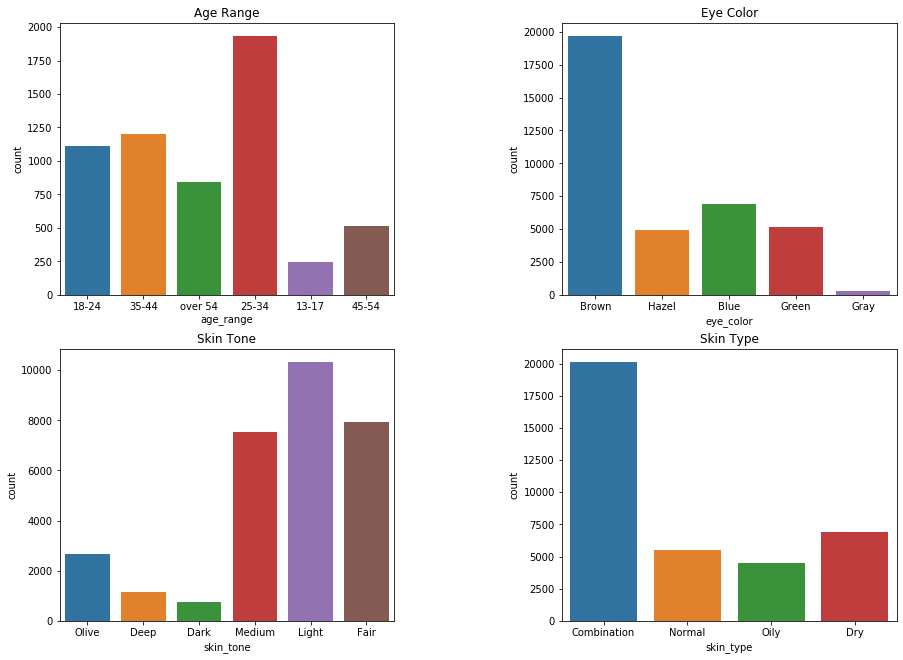

<Figure size 468x468 with 0 Axes>

In [242]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 11))
plt.subplots_adjust(wspace = .5)
plt.figure(figsize = (6.5,6.5))

sns.countplot(data = reviews, x = 'age_range', ax = axes[0,0])
axes[0,0].set_title('Age Range')


sns.countplot(data = reviews, x = 'eye_color', ax = axes[0,1])
axes[0,1].set_title('Eye Color')


sns.countplot(data = reviews, x = 'skin_tone', ax = axes[1,0])
axes[1,0].set_title('Skin Tone')


sns.countplot(data = reviews, x = 'skin_type', ax = axes[1,1])
axes[1,1].set_title('Skin Type')


Most of the users were 25-34, with skin tone that ranges from fair to medium, had brown eyes and combination skin

# All the Pieces Together

In [493]:
w_ratings = pd.merge(products, ratings, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [494]:
w_summ = pd.merge(w_ratings, compound_summaries, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [495]:
w_summ.columns

Index(['brand_name', 'category', 'imageAltText', 'isLimitedEdition', 'isNew',
       'isOnlineOnly', 'isSephoraExclusive', 'listPrice', 'salePrice', 'skuId',
       'skuType', 'valuePrice', 'review_count_x', 'target_x', '1 star',
       '2 stars', '3 stars', '4 stars', '5 stars', 'avg_rating',
       'product_id_x', 'review_count_y', 'total_ratings', 'target_y',
       'compound_score', 'product_id_y'],
      dtype='object')

In [496]:
w_summ.drop(columns = ['product_id_x', 'product_id_y', 'target_y'], inplace = True)

In [497]:
final_df = pd.merge(w_summ, compound_ratings, how = 'left', left_on = 'skuId', right_on = 'product_id')

In [498]:
final_df.drop_duplicates(subset = 'skuId', inplace = True)

In [499]:
final_df.drop(columns = 'review_count_x', inplace = True)

In [500]:
final_df.to_csv('final_dataset.csv')

In [502]:
final_df.corr()['target_x']

isLimitedEdition      0.132540
isNew                -0.057468
isOnlineOnly         -0.010396
isSephoraExclusive    0.184555
listPrice            -0.052381
salePrice             0.769436
skuId                 0.002788
target_x              1.000000
1 star               -0.039832
2 stars              -0.049086
3 stars              -0.052970
4 stars              -0.051734
5 stars              -0.054387
avg_rating           -0.136607
review_count_y       -0.054961
total_ratings        -0.054961
compound             -0.113889
Name: target_x, dtype: float64